In [41]:
from eda_imports import *
import matplotlib.patches as patches

In [2]:
print(datetime.datetime.today().date())

2018-07-25


In [3]:
%time adf = pd.read_pickle('../../benchmark_transcriptome/UHRC1/polyA.KLEAT.hexamer-researched.pkl')

CPU times: user 19.3 ms, sys: 21.4 ms, total: 40.8 ms
Wall time: 120 ms


# map clv to a closest clustered annotated CS

In [8]:
# this one hasn't been clustered yet
df_clv_sc = pd.read_pickle('clv-sc-mapping-hg19.pkl')

In [10]:
df_clv_sc.rename(columns={'clv': 'aclv'}, inplace=True)

In [11]:
# first create a dict of gene-to-clvs map
# ONLY use the mclv value in annotation, its clv is mainly for debugging purpose
ANNOT_GENE2CLV_DD = df_clv_sc.groupby(['gene_name']).apply(lambda g: g.aclv.unique())
def map_kclv2aclv(row):
    """map KLEAT predicted clv to a closest annotated clv"""
    gene = row.gene_name
    kclv = row['clv']
    poss_aclvs = ANNOT_GENE2CLV_DD[gene]
    return poss_aclvs[np.argmin(np.abs(poss_aclvs - kclv))]

In [12]:
_df = adf[['gene_name', 'clv']].drop_duplicates()

In [13]:
_df.shape[0]

54917

In [14]:
%time _df['aclv'] = _df.apply(map_kclv2aclv, axis=1)

CPU times: user 4.12 s, sys: 32.2 ms, total: 4.15 s
Wall time: 4.11 s


In [15]:
%time bdf = adf.merge(_df, on=['gene_name', 'clv'], how='left')

CPU times: user 55 ms, sys: 1.28 ms, total: 56.2 ms
Wall time: 54.4 ms


In [16]:
bdf.shape[0]

54917

In [17]:
assert bdf.shape[0] == adf.shape[0]

In [18]:
bdf.head(1)

,gene_name,strand,seqname,clv,length_of_tail_in_contig,number_of_bridge_reads,max_bridge_read_tail_length,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,aclv
0,PALMD,+,chr1,100159930,0,1,8,100159929,AATAAA,1,100159911,100159912,100160097


In [19]:
# NDA: could be a misnomer, supposed to be unsigned-distance to annotated clv
bdf['signed_NDA'] = bdf['clv'] - bdf['aclv']
bdf['NDA'] = bdf['signed_NDA'].abs()

# Prepare filtering

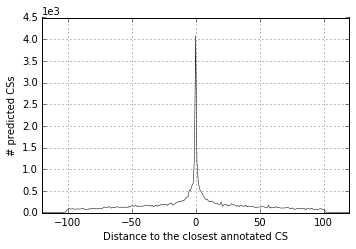

In [20]:
# ax = bdf_flag1['signed_NDA'].value_counts().sort_index().plot(lw=0.5, color='black', linestyle='--', label='flag = 1')
# bdf_flag2['signed_NDA'].value_counts().sort_index().plot(ax=ax, lw=0.5, color='black', linestyle='-.', label='flag = 2')
# bdf['signed_NDA'].value_counts().sort_index().plot(ax=ax, lw=0.5, color='black', linestyle='-', label='both')

fig = plt.figure(figsize=(5.5, 3.5))
ax = fig.add_subplot(111)
bdf['signed_NDA'].value_counts().sort_index().plot(ax=ax, lw=0.5, color='black', linestyle='-')
ax.set_xlim(-120, 120)
# ax.set_ylim(0, 7e5)
ax.set_ylabel('# predicted CSs')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
ax.grid()
ax.set_xlabel('Distance to the closest annotated CS')
ax.legend().remove()
# plt.savefig('./results/figs/distr-of-NDA-before-2nd-filtering.jpg', dpi=350)

In [21]:
# hc_b2f: hexamer count before 2nd filtering
hc_b2f_with_NA_counts = bdf.hexamer.value_counts().to_frame('After initial filtering')
hc_b2f_with_NA = (bdf.hexamer.value_counts() / bdf.hexamer.value_counts().sum()).to_frame('After initial filtering')

# Start filtering

```
awk '($11>=4 || $13>=2 || $14>=4) && ($20!="-")'

length_of_tail_in_contig MINIMUM OF 4 OR
number_of_bridge_reads MINIMUM OF 2 OR
max_bridge_read_tail_length MINIMUM OF 4 (i.e. OK if there is just one bridge read, but it must have at least 4 A's)

ONE of the above AND there must be a hexamer motif (doesn't matter how strong it is)
```

In [22]:
cdf = bdf[
    (
        bdf.NDA <= 25
    ) 
    | 
    (    
        (
            (bdf.length_of_tail_in_contig >= 4) | 
            (bdf.number_of_bridge_reads >= 2) |
            (bdf.max_bridge_read_tail_length >= 4)
        )
        & 
        (
            bdf.hexamer.isin(["AATAAA", "ATTAAA"])
        )
    )
].copy()

In [23]:
cdf.shape[0]

22650

In [25]:
print('{0:.3%} data remained'.format(cdf.shape[0] / adf.shape[0]))

41.244% data remained


In [26]:
hc_a2f_with_NA_counts = cdf.hexamer.value_counts().to_frame('After second filtering')
hc_a2f_with_NA = (cdf.hexamer.value_counts() / cdf.hexamer.value_counts().sum()).to_frame('After second filtering')

/projects/btl2/zxue/kleat/venv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


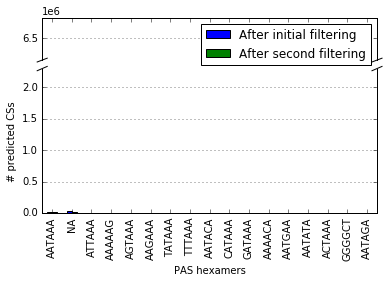

In [27]:
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

fig = plt.figure(figsize=(6, 3.5))
nrows = 12
ratio = 1 / (1 + 3) # meaning the first subplot is 1/3 height of the second one
gs = gridspec.GridSpec(nrows, 1, hspace=1)
ax1 = fig.add_subplot(gs[:int(nrows * ratio), :])
ax2 = fig.add_subplot(gs[int(nrows * ratio):,:])

merged = hc_b2f_with_NA_counts\
    .merge(hc_a2f_with_NA_counts, left_index=True, right_index=True, how='outer')\
    .fillna(0).sort_values('After second filtering', ascending=False)

merged.plot.bar(ax=ax1)
merged.plot.bar(ax=ax2)
    
ylim_max = 2.3e6
ax2.set_ylim(0, ylim_max)  # most of the data
ax1.set_yticks(np.arange(6e6, 7.5e6, 5e5))
ax1.set_ylim(6.1e6, 6.1e6 +  ylim_max * ratio / (1 - ratio))  # outliers only

ax2.legend().set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.set_xlabel('')
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xlabel('PAS hexamers')
ax2.set_ylabel('# predicted CSs')
ax1.yaxis.grid(zorder=0)
ax2.yaxis.grid(zorder=0)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(flip(handles, 2), flip(labels, 2), loc='upper right', ncol=2)

scaler = 1 / ratio - 1
ax1.plot((-d, +d), (-d * scaler, d * scaler), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d * scaler, d * scaler), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
# http://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
ax2.yaxis.offsetText.set_visible(False)

# plt.savefig('./figs/hexamer_counts.jpg', dpi=350, bbox_inches='tight')

In [28]:
hc_a2f_with_NA.T

,AATAAA,NA,ATTAAA,AAAAAG,AGTAAA,AAGAAA,TATAAA,TTTAAA,AATACA,CATAAA,GATAAA,AAAACA,AATGAA,AATATA,ACTAAA,GGGGCT,AATAGA
After second filtering,0.420706,0.323709,0.104503,0.021148,0.018543,0.016424,0.01585,0.010817,0.010596,0.010066,0.008962,0.008035,0.007947,0.007152,0.006049,0.005475,0.004018


# Plot the distributions again

In [29]:
cdf.query('NDA > 10').shape[0] / cdf.shape[0]

0.3692273730684327

In [30]:
cdf.query('NDA <= 15').shape[0] / cdf.shape[0]

0.7415011037527593

In [31]:
cdf.query('NDA <= 10').shape[0] / cdf.shape[0]

0.6307726269315673

Text(0,0.5,'# predicted CSs')

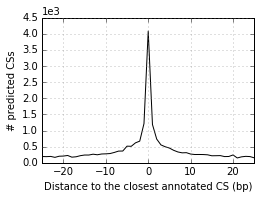

In [44]:
fig = plt.figure(figsize=(3.8, 2.6))
ax = fig.add_subplot(111)

ax = cdf['signed_NDA'].value_counts().sort_index().plot(lw=1, color='black', label='distance to an annotated CS')
ax.set_xlim(-25, 25)
# ax.set_ylim(0, 4.2e5)
# ax.set_yscale('log')
ax.grid(lw=0.5, color='gray')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 2))
ax.set_xlabel('Distance to the closest annotated CS (bp)')
ax.set_ylabel('# predicted CSs')

# ax.legend()
# plt.savefig('../__results/figs/distr-of-non-signed-distance-to-annotated-clv.jpg', bbox_inches='tight', dpi=500)

#### distr. of distance to hexamer

In [34]:
ddf = cdf.query('hexamer_id != -1').copy()
ddf['sdist_clv2hex'] = ddf['clv'] - ddf['hexamer_loc']
ddf['dist_clv2hex'] = ddf.sdist_clv2hex.abs()
ddf['sdist_aclv2hex'] = ddf['aclv'] - ddf['hexamer_loc']
ddf['dist_aclv2hex'] = ddf.sdist_clv2hex.abs()

In [35]:
ddf.shape[0] / cdf.shape[0]

0.6762913907284768

So 67.6% of the CSs have an associated hexamer

In [36]:
ddf.head(1)

,gene_name,strand,seqname,clv,length_of_tail_in_contig,number_of_bridge_reads,max_bridge_read_tail_length,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,aclv,signed_NDA,NDA,sdist_clv2hex,dist_clv2hex,sdist_aclv2hex,dist_aclv2hex
0,PALMD,+,chr1,100159930,0,1,8,100159929,AATAAA,1,100159911,100159912,100160097,-167,167,18,18,185,18


Tried to extract annotated hexamer loc

Settle: using the distance between aclv and hexamer found based on annotated clv (before clustering) is too complicated, as the region changes before and after clustering, so just ignore it and use the distance between KLEAT clv and hexamer found based on it instead.

Text(0.5,0,'dist to hexamer (bp)')

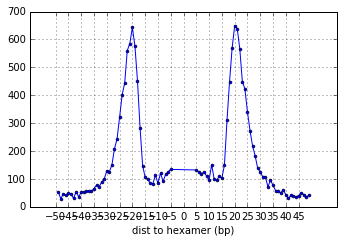

In [37]:
# this is a crude version: this plot confirms the minimum dist is 5 bp 
fig = plt.figure(figsize=(5.5, 3.5))
ax = ddf['sdist_clv2hex'].value_counts().sort_index().plot(marker='o', markersize=3)
ax.grid()
_ = ax.set_xticks(np.arange(-50, 50, 5))
ax.set_xlabel('dist to hexamer (bp)')

In [38]:
ddf.query('strand == "-"').sdist_clv2hex.value_counts().head()

-20    643
-21    585
-19    576
-22    560
-18    451
Name: sdist_clv2hex, dtype: int64

In [39]:
ddf.query('strand == "+"').sdist_clv2hex.value_counts().head()

20    649
21    639
19    569
22    566
23    449
Name: sdist_clv2hex, dtype: int64

So the most probable dist is around 21 bp for both strands

In [45]:
%time cdf.to_pickle('../../benchmark_transcriptome/UHRC1/polyA.KLEAT.hexamer-researched.filtered.pkl')

CPU times: user 10.4 ms, sys: 7.68 ms, total: 18.1 ms
Wall time: 55.2 ms
